# CS4487 - Machine Learning
# Lecture 10a - Deep Learning 2
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- Image Classification and Deep Architectures
- Unsupervised Learning

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

rbow = plt.get_cmap('rainbow')

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklear

In [2]:
# use TensorFlow backend
%env KERAS_BACKEND=tensorflow     
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, \
                Input, MaxPooling2D, UpSampling2D, Lambda, Reshape, BatchNormalization, \
                GlobalAveragePooling2D
import keras
import tensorflow
import logging
logging.basicConfig()
import struct

# use channels first representation for images
from keras import backend as K
K.set_image_data_format('channels_first')

from keras.callbacks import TensorBoard

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [3]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['acc'], 'b', label="training acc ({:.4f})".format(history.history['acc'][-1]))
        ax2.plot(history.history['val_acc'], 'b--', label="validation acc ({:.4f})".format(history.history['val_acc'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [4]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            if ndim(cur_W) == 2:
                plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            else:
                plt.imshow(cur_W,interpolation='nearest')  
                
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles % idx)
                elif isinstance(titles, list):
                    plt.title(titles[idx])
                else:
                    plt.title(titles)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()



# Image Classification
- **Goal:** given an image, predict the object class
  - typically only one main object is present
  - If enough classes are considered, then it's a generic high-level vision task
  
<center><img src='imgs/imagenet-objects.jpg' width=500></center>

# ImageNet
- ImageNet Large Scale Visual Recognition Challenge (ILSVRC)
  - 1000 image classes
  - 1.2 million images
  - Human performance: ~5.1%

<center><img src='imgs/imagenet-collage.png'></center>

# Performance of Deep Learning
- The introduction of ILSVRC coincided with the emergence of Deep Learning.
- Top-5 error rate decreased as deeper NN were developed
  - Not just deeper, but also the architecture design was smarter
  
<center><img src='imgs/imagenet-methods.png' width=600></center>

# LeNet-5 (1998)

- The standard CNN architecture
  - 7 layers
  - convolutions & pooling, final fully-connected layer
- Designed for hand-written digit recongition (MNIST)

<center><img src="imgs/LeNet.png" width=800></center>

# AlexNet
- Similar architecture to LeNet, but deeper (14 layers)
  - 11x11, 5x5, 3x3 convolutions
- Tricks used: DropOut, ReLU, max pooling, data augmentation, SGD momentum
- One of the first networks trained on GPU
  - (it is split in two pipelines because it was trained on 2 GPUs simultaneously)

<center><img src="imgs/AlexNet.png"></center>

# VGGnet
- Same style as LeNet and AlexNet
- Design choices:
  - only use 3x3 convolution filters (less parameters)
  - stack several convolution layers one after another, followed by pooling
    - equivalent to using a larger filter, but with less parameters.
  - number of feature channels doubles after each stage.
    - more higher-level features
    

<center><img src="imgs/VGG16.png"></center>

# InceptionNet
- "Network-in-Network" architecture
  - Core building blocks (modules), consisting of several layers, are combined repeatedly.
- Inception Module
  - several convolution filters in parallel
    - extract features at different scales (1x1, 3x3, 5x5)
    - pool features (3x3 max)
  - features are concatenated and passed to next block.
<center><img src="imgs/Inception-Module.png" width=500></center>

# InceptionNet (V1)
- 9 inception modules, 22 layers
  - 50 convolution blocks
- Auxiliary classification tasks (Needed because the update of weights from the final result to the top would be too diluted)
  - using features in the middle of the network to perform classification
  - strengthen supervisory signals to the middle and earlier layers.
<center><img src="imgs/InceptionNet.png"></center>

# Residual Learning
- The network is learning a function (image to class)
  - build the function block-by-block
  - each block learns a residual, which is added to the previous block
    - keep all the previous information and make small changes with the residual
<center><img src="imgs/ResNet-Block.png" width=300></center>

# Residual Network (ResNet)
- 34 layers, 50 layers, 100 layers, 1000 layers
  - 3x3 filters
  - residual connection every two layers.
<center><img src="imgs/ResNet-full.png"></center>

# Error vs. Computation vs. Number of Parameters
<center><img src="imgs/Comparison.png"></center>

# Image Classifiers in Keras
- Keras includes several pre-trained image classifier networks
  - VGG16, VGG19, ResNet50, InceptionV3, ...
  - already trained on ImageNet
- Can use these networks to:
  - perform image classification (for 1000 classes only)
  - extract image features for our own task
  - transfer learning - modify/adapt a pre-trained network for our own task

- Import the ResNet model class and support functions
- Load and pre-process the image for the network

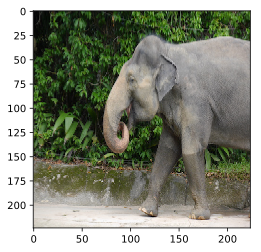

In [5]:
# contains the model and support functions for ResNet50
import keras.applications.resnet50 as resnet
from keras.preprocessing import image

# load an image 
img_path = 'imgs/elephant1.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # ResNet expects this size
plt.imshow(img)

# process the image for resnet
xi = image.img_to_array(img)
xi = expand_dims(xi, axis=0)
xi = resnet.preprocess_input(xi)

- Create an instance of the ResNet50 model
  - trained on ImageNet
  - will download the model if loading for the first time.

In [6]:
# create an instance of the model
model = resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 224, 224)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 230, 230)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 112, 112) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 112, 112) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\applications\resnet50.py:281: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


- Look at the 1000 classes

In [7]:
tmp = resnet.decode_predictions(eye(1000), top=1)  # decode the 1000-dim class vector
tmp2 = [i[0][1] for i in tmp]
tmp2.sort()
print(" ".join(tmp2))

Afghan_hound African_chameleon African_crocodile African_elephant African_grey African_hunting_dog Airedale American_Staffordshire_terrier American_alligator American_black_bear American_chameleon American_coot American_egret American_lobster Angora Appenzeller Arabian_camel Arctic_fox Australian_terrier Band_Aid Bedlington_terrier Bernese_mountain_dog Blenheim_spaniel Border_collie Border_terrier Boston_bull Bouvier_des_Flandres Brabancon_griffon Brittany_spaniel CD_player Cardigan Chesapeake_Bay_retriever Chihuahua Christmas_stocking Crock_Pot Dandie_Dinmont Doberman Dungeness_crab Dutch_oven Egyptian_cat English_foxhound English_setter English_springer EntleBucher Eskimo_dog European_fire_salamander European_gallinule French_bulldog French_horn French_loaf German_shepherd German_short-haired_pointer Gila_monster Gordon_setter Granny_Smith Great_Dane Great_Pyrenees Greater_Swiss_Mountain_dog Ibizan_hound Indian_cobra Indian_elephant Irish_setter Irish_terrier Irish_water_spaniel Iris

- Predict on the loaded image

In [8]:
# make a prediction on the image
preds = model.predict(xi)

# decode the results into a list of tuples (class, description, probability)
predsc = resnet.decode_predictions(preds, top=3)[0]

for i in predsc:
    print(i)

('n02504013', 'Indian_elephant', 0.8495556)
('n01871265', 'tusker', 0.14817366)
('n02504458', 'African_elephant', 0.0022699893)


# Pre-trained Image Features
- The network is trained on ImageNet, which contains many classes and images.
- The learned features generalize well to other tasks
  - capture high-level discriminative information about objects

In [9]:
# load dessert dataset
import glob

imglist = glob.glob('imgs/dessert/*/*.jpg')
Xraw = []
Xim = zeros((len(imglist), 3, 224, 224))
Ylab = []
for i,img_path in enumerate(imglist):
    img = image.load_img(img_path, target_size=(224, 224))
    Xraw.append(img)
    x = image.img_to_array(img)
    x = expand_dims(x, axis=0)
    x = resnet.preprocess_input(x)
    Xim[i,:] = x
    Ylab.append(img_path.split('\\')[1])

In [10]:
print(Xim.shape)
print(len(Ylab))

(200, 3, 224, 224)
200


In [11]:
# convert class strings into integers
print("class labels (strings):", unique(Ylab))
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Ylab)
print("Converted labels:")
print(Y)

class labels (strings): ['frozen_yogurt' 'ice_cream']
Converted labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


- Show a few examples of "ice cream" and "frozen yogurt"

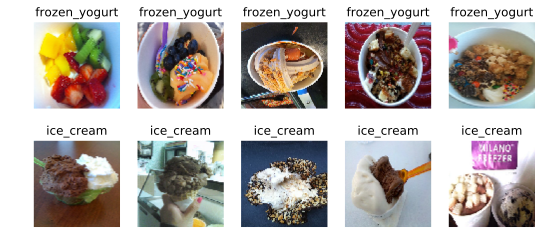

In [12]:
inds = [0, 1, 2, 3, 4, -1, -2, -3, -4, -5]
tmp = [Xraw[i] for i in inds]
t =  [Ylab[i] for i in inds]
plt.figure(figsize=(9,4))
show_imgs(tmp, nc=5, titles=t)

# Computing Image Features
- Use the pre-trained network as a feature extractor
  - remove the last layer (the classifier)
  - apply average pooling on the feature map
    - 7x7x2048 --> 1x2048

In [13]:
# create an instance of the model w/o the last layer
model_f = resnet.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# compute the features
Xf = model_f.predict(Xim)
print(Xf.shape)

C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\applications\resnet50.py:281: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


(200, 2048)


- Now use the features to train a binary classifier
- First setup the dataset

In [14]:
# convert class labels to binary indicators
Yb = keras.utils.np_utils.to_categorical(Y)

# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainXim, testXim,     # pre-processed images
  trainYb, testYb ,      # binary class vector (for Keras)
  trainXraw, testXraw    # original images
) = \
  model_selection.train_test_split(Xf, Y, Xim, Yb, Xraw, 
  train_size=0.8, test_size=0.2, random_state=4487)

trainX = trainXim.reshape((trainXim.shape[0], -1))
testX  = testXim.reshape((testXim.shape[0], -1))

print(trainXf.shape)
print(testXf.shape)
print(trainXim.shape)
print(trainX.shape)

(160, 2048)
(40, 2048)
(160, 3, 224, 224)
(160, 150528)


- Setup validation set for later

In [15]:
# generate a fixed validation set using 10% of the training set
vtrainXim, validXim, vtrainYb, validYb = \
  model_selection.train_test_split(trainXim, trainYb, 
  train_size=0.9, test_size=0.1, random_state=6487)

# validation data
validset  = (validXim, validYb)

- Use the image features to train a standard SVM classifier

In [16]:
# setup the list of parameters to try
paramgrid = {'C': logspace(-3,3,13)}
print(paramgrid)

# setup cross-validation
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5,
                                     n_jobs=-1, verbose=True)

# run cross-validation (train for each split)
svmcv.fit(trainXf, trainY);

{'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])}
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   30.3s finished


- Predict with the classifier
- The accuracy is great!

In [17]:
# predict
predY = svmcv.predict(testXf)

acc = metrics.accuracy_score(testY, predY)
print("test accuracy = " + str(acc))

test accuracy = 0.95


- For comparison, also train an SVM on the raw images
- The accuracy is really bad (almost chance level)

In [18]:
svmcv_im = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5,
                                     n_jobs=-1, verbose=True)

# run cross-validation (train for each split)
svmcv_im.fit(trainX, trainY);


# Directly use svmcv to make predictions
predY = svmcv_im.predict(testX)

acc = metrics.accuracy_score(testY, predY)
print("test accuracy = " + str(acc))

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  5.5min finished


test accuracy = 0.6


# Transfer learning and fine-tuning
- The network can also be "fine-tuned" for a new image classification task.
  - This is called transfer learning.
- Rather than retrain the whole network, 
  - fix the lower layers that extract features (no need to train them since they are good features)
  - train the last few layers to perform the new task
- Does not need as much data, compared to the original ImageNet.

- First, let's see ResNet50 predicts on our images

In [19]:
# try the original ResNet50
testYscore = model.predict(testXim)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


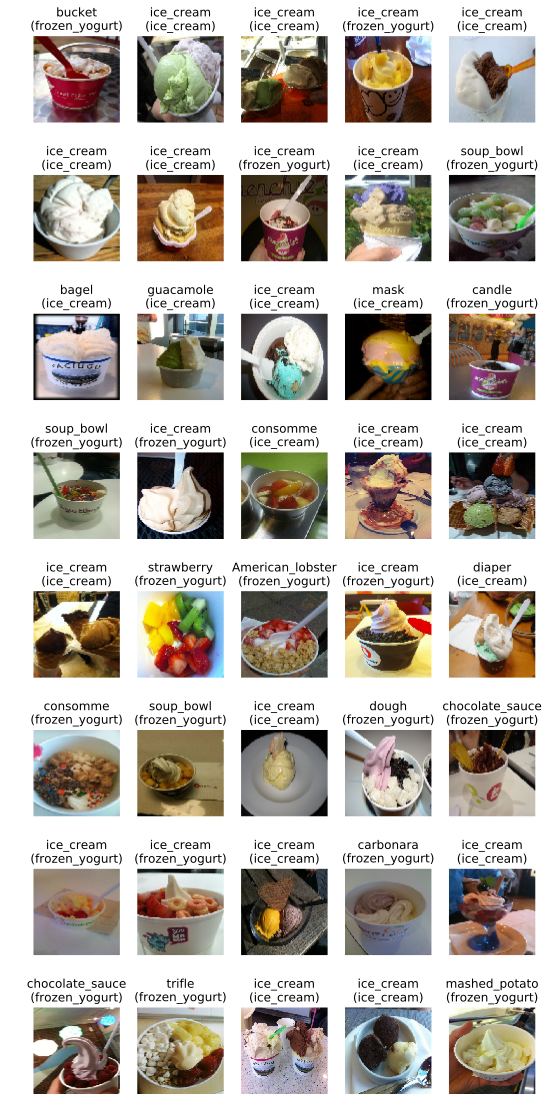

In [20]:
# get the class labels
predY = resnet.decode_predictions(testYscore, top=1)
testYcl = le.inverse_transform(testY)

# make titles
titles = []
for i in range(len(predY)):
    titles.append(predY[i][0][1] + "\n(" + testYcl[i] + ")")

# make a plot: predicted (true)    
plt.figure(figsize=(9,20))
show_imgs(testXraw, nc=5, titles=titles)

- We will use the `Model` class
  - allows for more complex layer interactions than "Sequential"
- Connect layers one-by-one
  - instantiate the layer (with hyperparameters)
  - then pass the previous layer to it.

In [21]:
#random.seed(4487); tensorflow.set_random_seed(4487)

# create the base pre-trained model with-out the classifier
base_model = resnet.ResNet50(weights='imagenet', include_top=False)

# start with the output of the ResNet50 (7x7x2048)
x = base_model.output

# for each channel, average all the features (1x2048)
x = GlobalAveragePooling2D()(x)

# fully-connected layer (1 x32)
# (only two classes so don't need so many)
x = Dense(32, activation='relu')(x)

# finally, the softmax for the classifier (2 classes)
predictions = Dense(2, activation='softmax')(x)

C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\applications\resnet50.py:281: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


- Create the Model
  - specify the input and output layers
  - the network is everything in between
- Fix the weights of the layers of ResNet so they will not change during training

In [22]:
# build the model for training
# - need to specify the input layer and the output layer
model_ft = Model(inputs=base_model.input, outputs=predictions)

# fix the layers of the ResNet50.
for layer in base_model.layers:
    layer.trainable = False

# compile the model - only the layers that we added will be trained
model_ft.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

- Setup the data augmentation generator

In [23]:
from keras.preprocessing.image import ImageDataGenerator

def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.2,     # image shifting
    height_shift_range=0.2,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True, 
    preprocessing_function=add_gauss_noise, 
)

# fit (required for some normalization augmentations)
datagen.fit(vtrainXim)

- Train the model
  - only the last layers that we added are updated

In [24]:
# train the model on the new data for a few epochs
bsize = 32
callbacks_list = []
history = model_ft.fit_generator(
            datagen.flow(vtrainXim, vtrainYb, batch_size=bsize),  # data from generator
            steps_per_epoch=len(vtrainXim)/bsize,    # should be number of batches per epoch
            epochs=20,
            callbacks=callbacks_list, 
            validation_data=validset, verbose=True)

Epoch 1/20
5/4 [=================================] - 8s 2s/step - loss: 1.7913 - acc: 0.5457 - val_loss: 0.4450 - val_acc: 0.8750
Epoch 2/20
5/4 [=================================] - 2s 315ms/step - loss: 0.4373 - acc: 0.7946 - val_loss: 0.3448 - val_acc: 0.8750
Epoch 3/20
5/4 [=================================] - 2s 437ms/step - loss: 0.4330 - acc: 0.7575 - val_loss: 0.8560 - val_acc: 0.4375
Epoch 4/20
5/4 [=================================] - 2s 409ms/step - loss: 0.2627 - acc: 0.8709 - val_loss: 1.0783 - val_acc: 0.4375
Epoch 5/20
5/4 [=================================] - 2s 433ms/step - loss: 0.1937 - acc: 0.9363 - val_loss: 1.0863 - val_acc: 0.5000
Epoch 6/20
5/4 [=================================] - 2s 433ms/step - loss: 0.2710 - acc: 0.8762 - val_loss: 3.0577 - val_acc: 0.3750
Epoch 7/20
5/4 [=================================] - 2s 494ms/step - loss: 0.2476 - acc: 0.9045 - val_loss: 1.1604 - val_acc: 0.4375
Epoch 8/20
5/4 [=================================] - 2s 498ms/step - los

- Training/validation curves

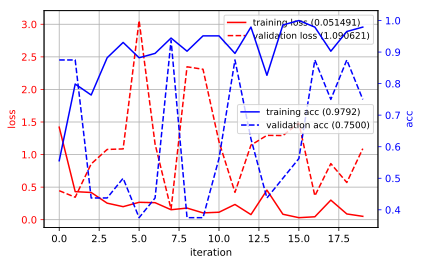

In [25]:
plot_history(history)

- Compute test accuracy

In [26]:
predYscore = model_ft.predict(testXim, verbose=False)
predY = argmax(predYscore, axis=1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

test accuracy: 0.85


- Visualize the predictions

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


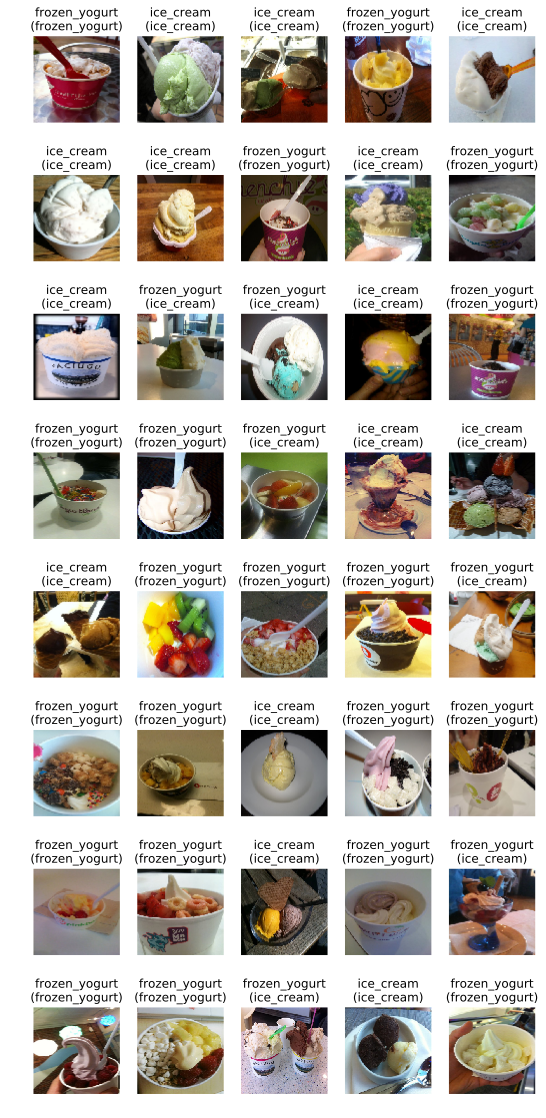

In [27]:
# get the class labels
predYcl = le.inverse_transform(predY)
# make titles
titles = []
for i in range(len(predYcl)):
    titles.append(predYcl[i] + "\n(" + testYcl[i] + ")")

# make a plot: predicted (true)    
plt.figure(figsize=(9,20))
show_imgs(testXraw, nc=5, titles=titles)